# Libraries

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch

from IPython.display import clear_output

import matplotlib.pyplot as plt
from PIL import Image

from itertools import product

from random import uniform

from pathlib import Path

import numpy as np

# Data

## Downloading the dataset of houses

In [ ]:
!gdown --id 1kOP1rMIiaU7nPhTJ4M8EsKIwMcvbz1-N

Downloading...
From: https://drive.google.com/uc?id=1kOP1rMIiaU7nPhTJ4M8EsKIwMcvbz1-N
To: /content/houses.zip
100% 193M/193M [00:04<00:00, 44.7MB/s]


In [ ]:
!unzip houses.zip
clear_output()

## Preparing datasets

In [ ]:
class HousesDatasetGAN(Dataset):
    '''our custom version of torch dataset for the pictures of houses'''

    def __init__(self, dataset_dir, transforms=None):
        '''save the paths to images of houses and transforms if needed'''
        self.houses_paths = list(map(str, Path(dataset_dir).rglob('*.jpg')))
        self.transforms   = transforms

    def __len__(self):
        '''size of list of paths'''
        return len(self.houses_paths)

    def __getitem__(self, idx):
        '''retrieve an image from path and return it's tranformed version'''

        # open the image in 3 channels 
        image = Image.open(self.houses_paths[idx]).convert('RGB')

        # transform it if needed
        if self.transforms is not None:
            image = self.transforms(image)

        # return in image and indicator that it is a real one
        return image, 1

In [ ]:
# heights and width of image
RESIZE_DIM = 64

# preparing the augmentations 
transforms = T.Compose([
    T.Resize((RESIZE_DIM, RESIZE_DIM)),
    T.RandomHorizontalFlip(),
    # T.RandomRotation(degrees=45),       #  <-- maybe it's a bad idea
    # T.GaussianBlur(kernel_size=(3, 3)), #  <-- same thing
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float)
])

# creating a train dataset
houses_dataset = HousesDatasetGAN('validated', transforms)

In [ ]:
!gdown --id 1a4j2wP80kaoKMLPZnDUOci--x1dN_4WI

Downloading...
From: https://drive.google.com/uc?id=1a4j2wP80kaoKMLPZnDUOci--x1dN_4WI
To: /content/celeba.zip
100% 1.44G/1.44G [00:23<00:00, 62.3MB/s]


In [ ]:
!unzip celeba.zip

## Visualizing dataset

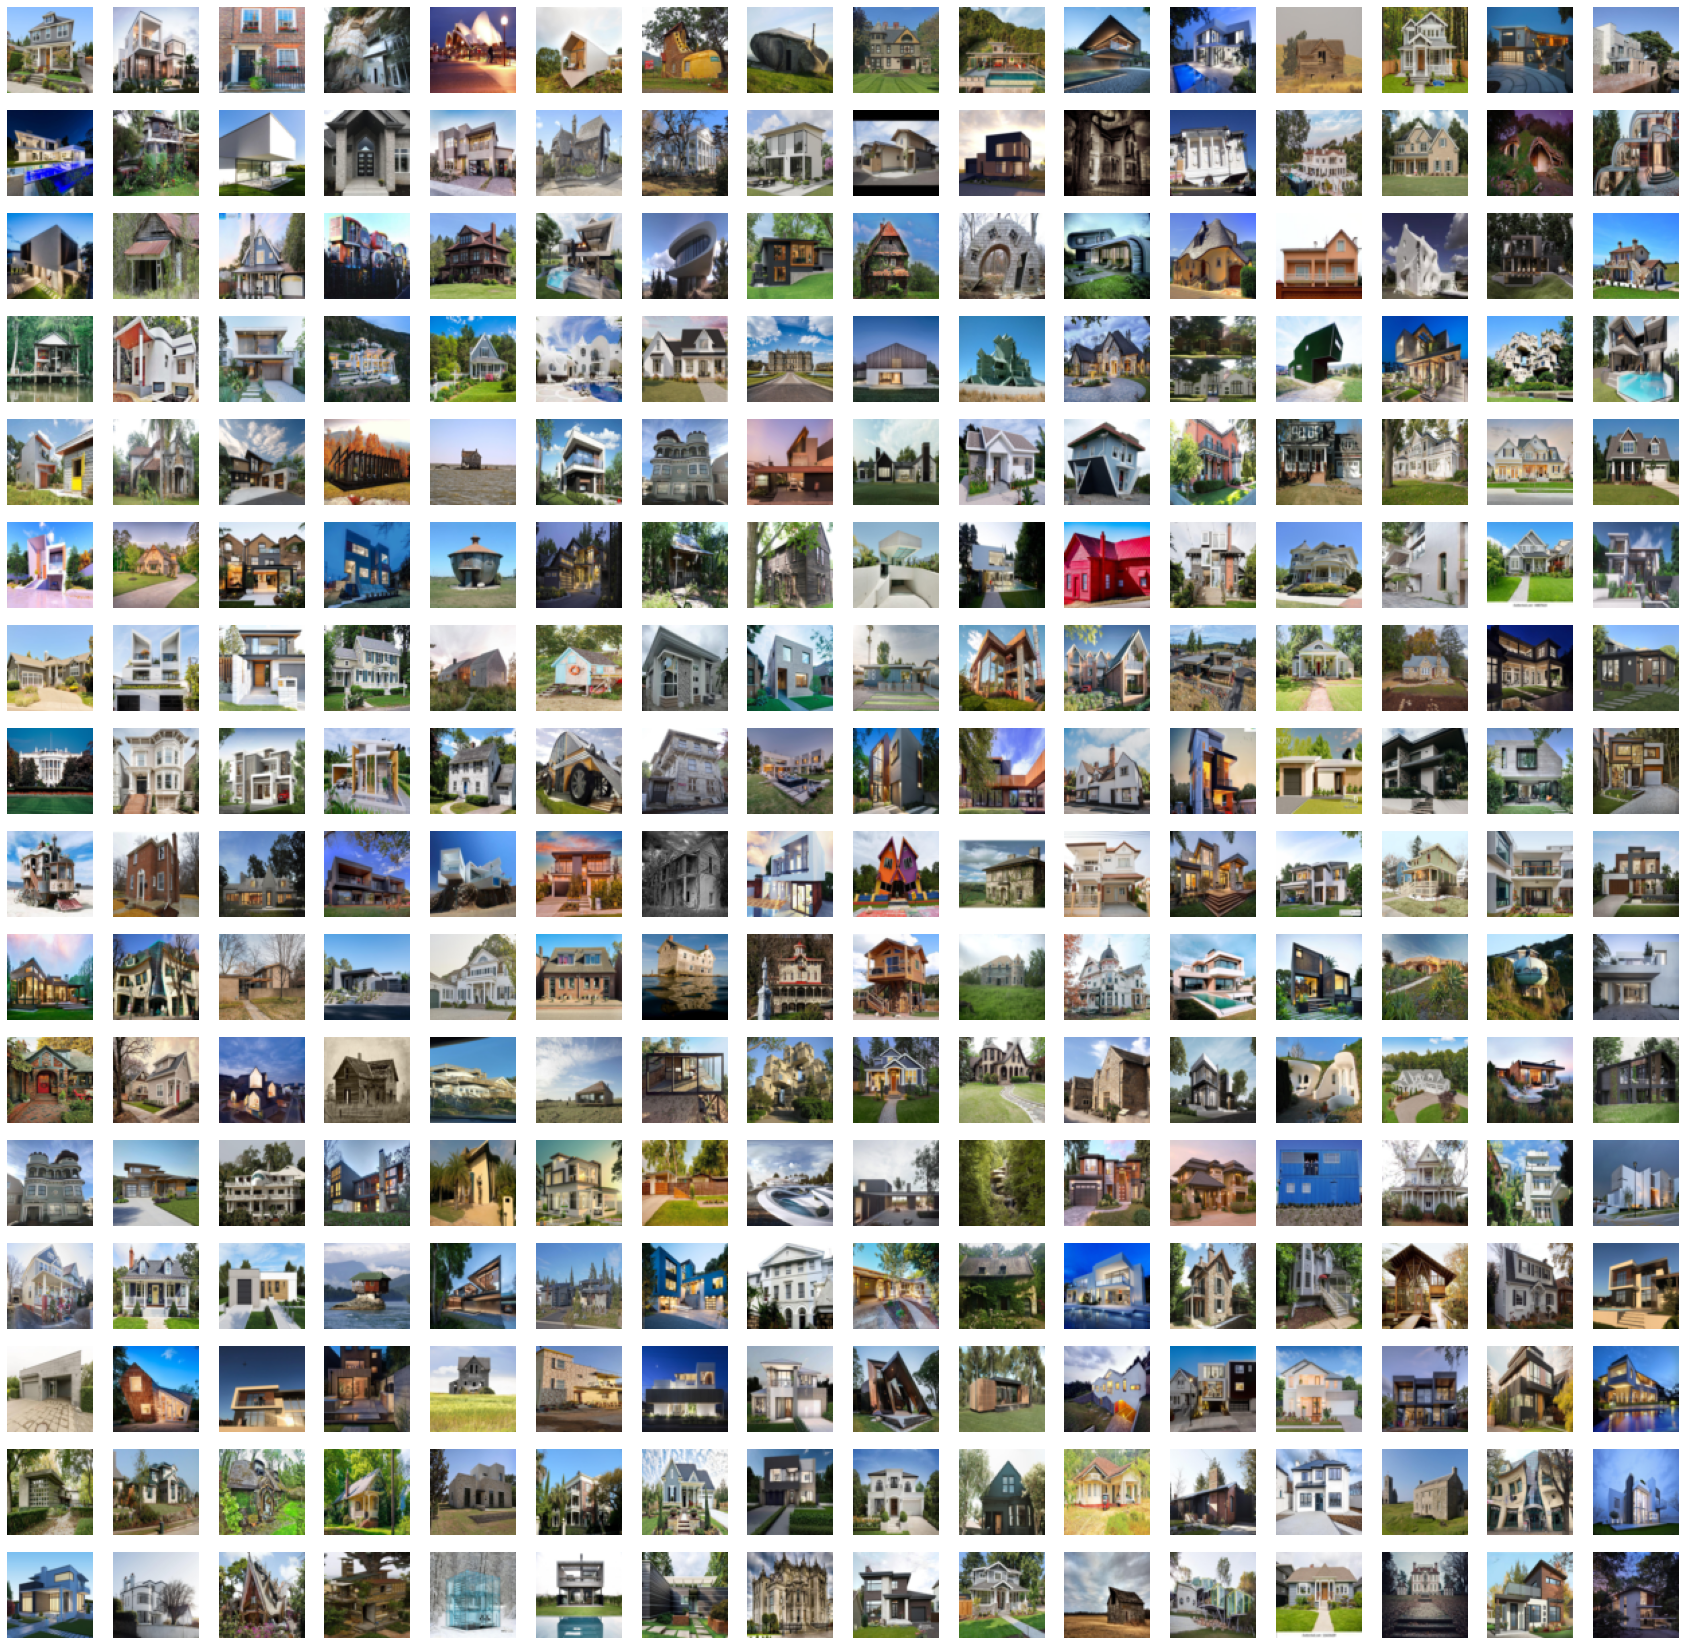

In [ ]:
# size of visualizing square
n_plots = 16

# grid visualizing the dataset
_, ax = plt.subplots(nrows=n_plots, ncols=n_plots, figsize=(30, 30))

# putting each item from dataset on the subplot
for i, j in product(range(n_plots), range(n_plots)):

    # get the next subsequent item from the dataset
    house = houses_dataset[i*n_plots+j][0]

    # resotring the PIL image from it
    house = T.ToPILImage()(house)

    # turn off the axis and plot the house
    ax[i, j].axis('off')
    ax[i, j].imshow(house)

# Building GAN

## Generator

In [ ]:
class Generator(nn.Module):
    '''Implementation of FCC-Generator'''

    def __init__(self, noise_dim=100):
        '''stacking layers'''

        # initilizing the super class instance
        super(Generator, self).__init__()

        # save the size of noise from which generator outputs image
        self.noise_dim = noise_dim

        # linear bois to get intermediate features
        self.lin_1 = nn.Linear(self.noise_dim, 64)
        self.lin_2 = nn.Linear(64,  512)
        self.lin_3 = nn.Linear(512, 8192)

        # batch normalizatiosn for linear layers 
        self.batch_norm_lin = nn.BatchNorm1d(8192)

        # dropout by the advice
        self.drop = nn.Dropout()

        # relu for linear layers
        self.relu = nn.ReLU()

        # transpose convolution layers
        self.convt_1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.convt_2 =        self._convt(256, 128, 4, 2, 1)
        self.convt_3 =        self._convt(128, 64,  4, 2, 1)
        self.convt_4 =        self._convt(64,  3,   4, 2, 1, last=True)

    def _convt(self, in_channels, out_channels,
               kernel_size, stride, padding, last=False):
        '''generate a transpose conv module with batch norm and leaky relu '''
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            self.relu if not last else nn.Tanh() # <-- from FCC-GAN paper
        )

    def _sample(self, batch_size=64):
        '''regerate samples from normal distribution'''
        return torch.randn((batch_size, self.noise_dim))

    def forward(self, x):
        '''propogate the noise through the generator'''

        # propogating through linear layers
        x = self.relu(self.lin_1(x))
        x = self.relu(self.lin_2(x))

        # normmalizing the outputs of last linear layer
        x = self.batch_norm_lin(self.lin_3(x))

        # reshaping the output for traspose convolutions
        x = x.view(-1, 512, 4, 4)

        # propogating through transpose convolutions
        x = self.convt_4(self.convt_3(self.convt_2(self.convt_1(x))))

        return x

In [ ]:
# Generator Code

class GeneratorDC(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.lin = nn.Linear(100, 8192)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 512, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        x = self.lin(x)
        x = x.view(-1, 512, 4, 4)
        return self.main(x)

In [ ]:
G = Generator(1)
print(G(torch.randn((64, 100))).size())

torch.Size([64, 3, 64, 64])


## Discriminator

In [ ]:
class Discriminator(nn.Module):
    '''our implementation of Discriminator class'''

    def __init__(self):
        '''initialize the layers'''

        # initialize an instance of nn.module class
        super(Discriminator, self).__init__()

        # activation functions
        self.leaky = nn.LeakyReLU(0.2)
        self.sigm  = nn.Sigmoid()

        # convolutional layers
        self.conv_1 = self._conv(3,   64,  4, 2, 1)
        self.conv_2 = self._conv(64,  128, 4, 2, 1)
        self.conv_3 = self._conv(128, 256, 4, 2, 1)
        self.conv_4 = self._conv(256, 512, 4, 2, 1)

        # transforing 3d input into 1d
        self.flat = nn.Flatten()

        # linear bois
        self.lin_1 = nn.Linear(8192, 512)
        self.lin_2 = nn.Linear(512,  64)
        self.lin_3 = nn.Linear(64,   16)
        self.lin_4 = nn.Linear(16,   1) # <-- last one, should output one number
                                        #     for binary classification

    def _conv(self, in_channels, out_channels,
              kernel_size, stride, padding):
        '''resuable convolutional layer with batch norm and leaky relu'''
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            self.leaky
        )

    def forward(self, x):
        '''propogate the image through discrimminator'''

        # propogating image through convolutions
        x = self.conv_4(self.conv_3(self.conv_2(self.conv_1(x))))

        # flatttening the input before linear bois
        x = self.flat(x)

        # sending output to linear bois
        x = self.leaky(self.lin_1(x))
        x = self.leaky(self.lin_2(x))
        x = self.leaky(self.lin_3(x))
        x = self.sigm(self.lin_4(x))

        return x

In [ ]:
class DiscriminatorDC(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

In [ ]:
D = Discriminator(1)
inp = torch.rand((64, 3, 64, 64))
print(D(inp).size())

torch.Size([64, 1])


# Training

In [ ]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [ ]:
# decide the device we're training on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# binary cross entropy loss
criterion = nn.BCELoss()

# models 
G = GeneratorDC(1).to(device)
D = DiscriminatorDC(1).to(device)

# optimizers for models
optim_g = torch.optim.RMSprop(G.parameters(), lr=5e-6, weight_decay=0.0005)
optim_d = torch.optim.RMSprop(D.parameters(), lr=5e-6, weight_decay=0.0005)

# # training data loader
train_loader = DataLoader(houses_dataset, 64, True)

# number of training cycles
epochs = 1000

# clipping value to cut off the gradients
clip_value = 0.01

# number of iterations for training D before training G
critic_iter = 5

In [ ]:
# training cycles
epochs = 1000
log_rate = 50
for epoch in range(epochs):
    for i, (real_images, ones) in enumerate(train_loader):

        # sending images and labels to the training device
        real_images, ones = real_images.to(device), ones.to(device)

        # smoothing the labels
        ones  = torch.tensor([uniform(0.7, 1.0) for _ in range(len(ones))]).view(-1, 1).float().to(device)
        zeros = torch.tensor([uniform(0, 0.3)   for _ in range(len(ones))]).view(-1, 1).float().to(device)

        ##########################
        # TRAINING DISCRIMINATOR #
        ##########################

        # resetting the gradients for discriminator's optimizer
        optim_d.zero_grad()

        # propogating the real images through discriminator
        d_pred_real = D(real_images)

        # calculating the loss on real images
        d_loss_real = criterion(d_pred_real, ones)

        # generating fake images 
        noise = torch.randn(len(ones), nz).to(device)
        fake_images = G(noise)

        # propogating fake images through discriminator
        d_pred_fake = D(fake_images)

        # getting the loss of discriminator on fake images
        d_loss_fake = criterion(d_pred_fake, zeros)

        # summing loss on fake and real imakes
        d_loss = d_loss_fake + d_loss_real

        # backpropogating the loss 
        d_loss.backward()

        # updating the weights on discriminator 
        optim_d.step()

        # clipping the weights
        for weight in D.parameters():
            weight.data.clamp_(-clip_value, clip_value)

        ######################
        # TRAINING GENERATOR #
        ######################

        # if reached critic iteration
        if not i % critic_iter:

            # resetting the gradients for generator's optimizer
            optim_g.zero_grad()

            # generating fake images
            another_fake_images = G(noise)

            # propogating them through discriminator
            another_d_pred_fake = D(another_fake_images)

            # calculating loss using inverse labels 
            g_loss = criterion(another_d_pred_fake, ones)

            # backpropogating the loss
            g_loss.backward()

            # updating the weights on generator
            optim_g.step()

    # loggin the losses of G and D
    # if not epoch % log_rate:
    print(f"Epoch: {epoch}, D loss: {d_loss}, G loss: {g_loss}")

Epoch: 0, D loss: 1.0968451499938965, G loss: 0.9207389950752258
Epoch: 50, D loss: 1.0210453271865845, G loss: 0.9962588548660278
Epoch: 100, D loss: 1.0019181966781616, G loss: 1.0294363498687744
Epoch: 150, D loss: 1.0029160976409912, G loss: 1.0284538269042969


KeyboardInterrupt: ignored

# Evaluation

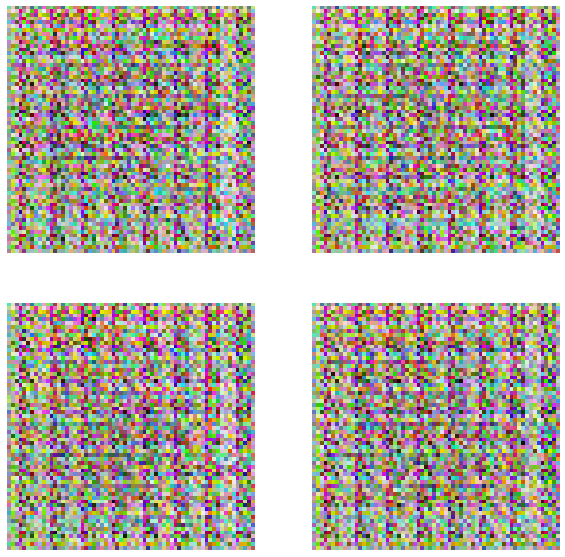

In [ ]:
# generating the images 
generated_houses = G(torch.randn(64, 100).to(device)).detach().cpu().numpy()

# size of visualizing square
n_plots = 2

# grid visualizing the dataset
_, ax = plt.subplots(nrows=n_plots, ncols=n_plots, figsize=(10, 10))

# putting each item from dataset on the subplot
for i, j in product(range(n_plots), range(n_plots)):

    # get the next subsequent item from the generated images
    house = generated_houses[i*n_plots+j]

    # interchanging channels dimension
    house = np.transpose(house, (1, 2, 0))

    # restoring 0-255 scaling
    house = ((house + 1) * 255 / 2).astype(np.uint8) 

    # turn off the axis and plot the house
    ax[i, j].axis('off')
    ax[i, j].imshow(house)

# References

* https://github.com/rajaswa/Digit-Generation-by-GAN/blob/master/main.ipynb
* https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe
* https://paperswithcode.com/paper/fcc-gan-a-fully-connected-and-convolutional
* https://colab.research.google.com/drive/1IObXtNogLVd3RjfhajrOZ96EU4MKBL4o
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py